In [1]:

pip install pandas numpy matplotlib seaborn scikit-learn

Saving DataSet1.csv to DataSet1.csv

--- Shape ---
 (5050, 20)

--- Column Names ---
 ['id', 'age', 'gender', 'education', 'marital_status', 'workclass', 'occupation', 'hours_per_week', 'capital_gain', 'capital_loss', 'native_country', 'annual_income', 'loan_status', 'experience_years', 'job_satisfaction', 'bmi', 'smoking_status', 'physical_activity', 'credit_score', 'disease_risk']

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5050 non-null   int64  
 1   age                5050 non-null   int64  
 2   gender             5050 non-null   object 
 3   education          5050 non-null   object 
 4   marital_status     5050 non-null   object 
 5   workclass          4798 non-null   object 
 6   occupation         4798 non-null   object 
 7   hours_per_week     5050 non-null   int64  
 8   

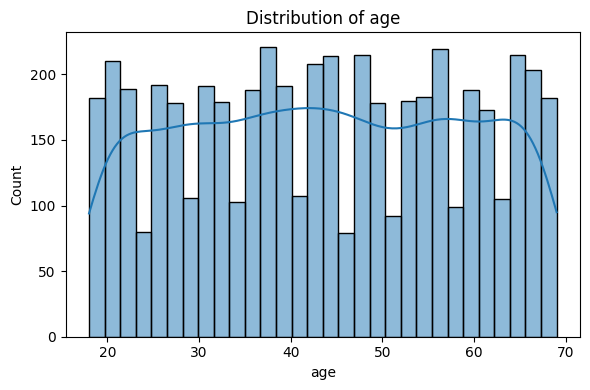

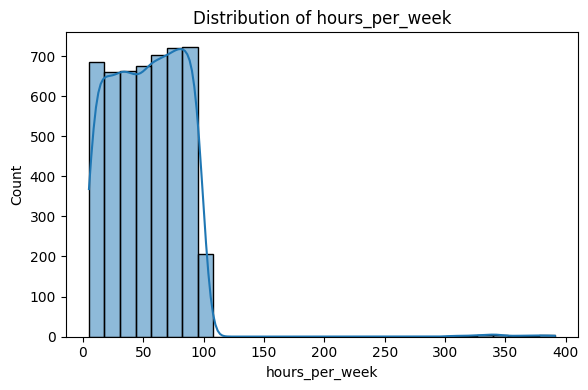

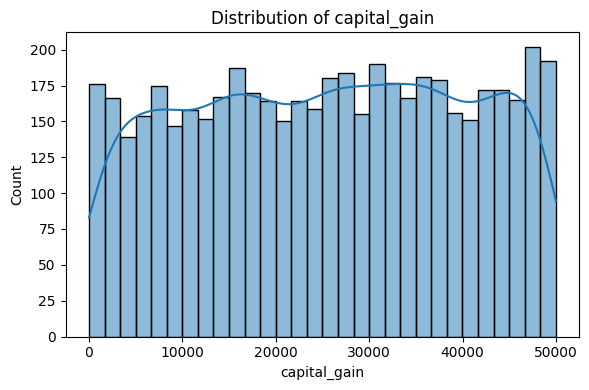

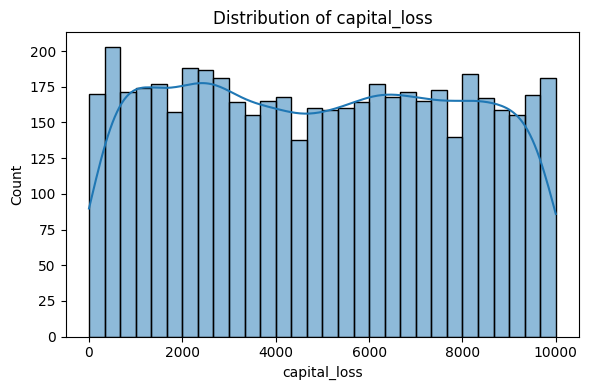

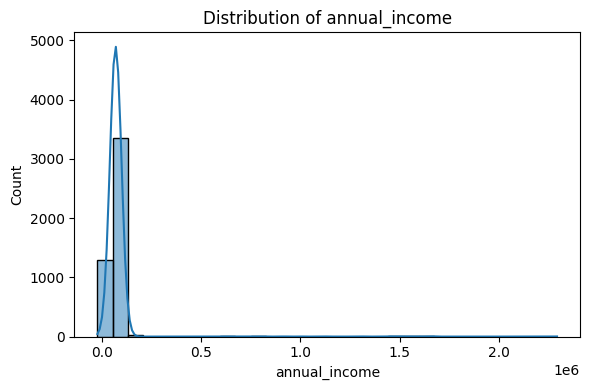

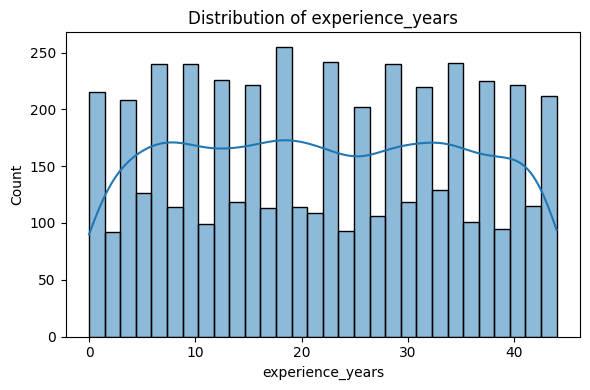

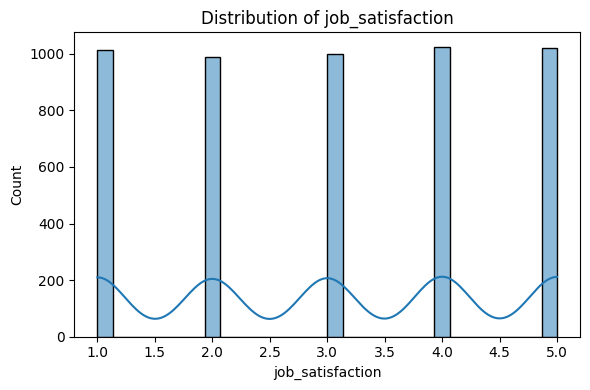

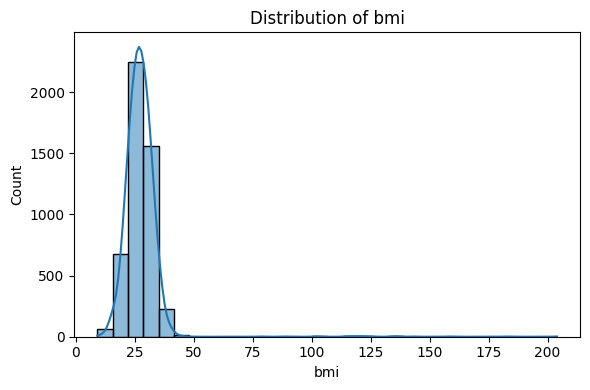

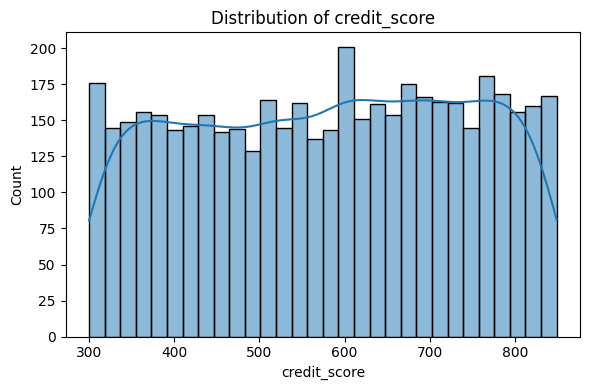

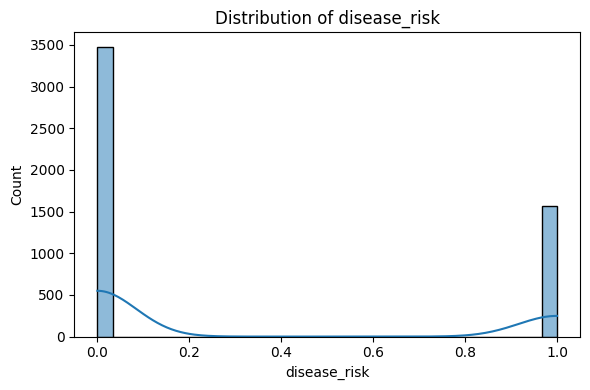

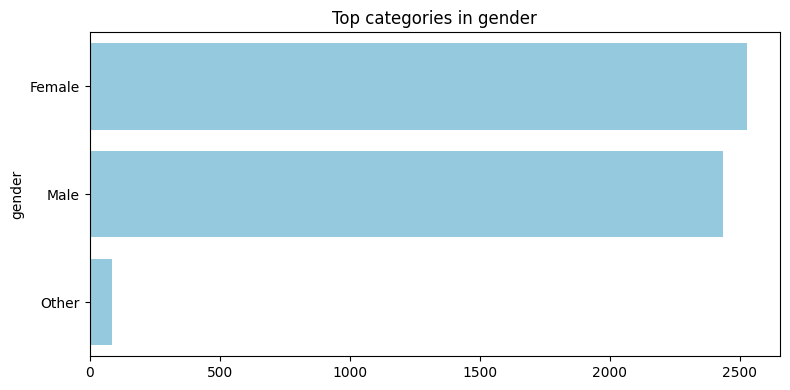

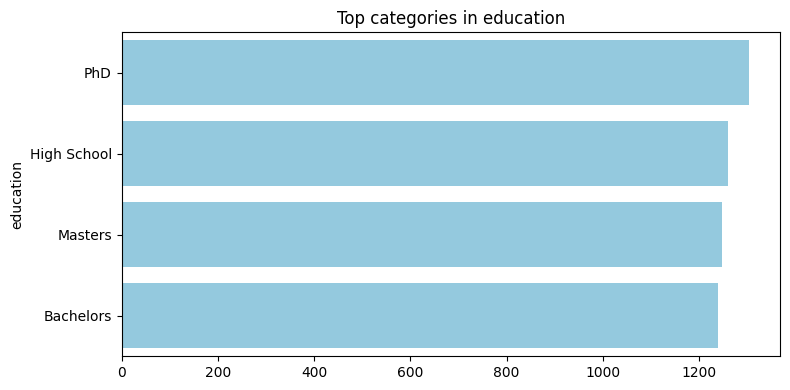

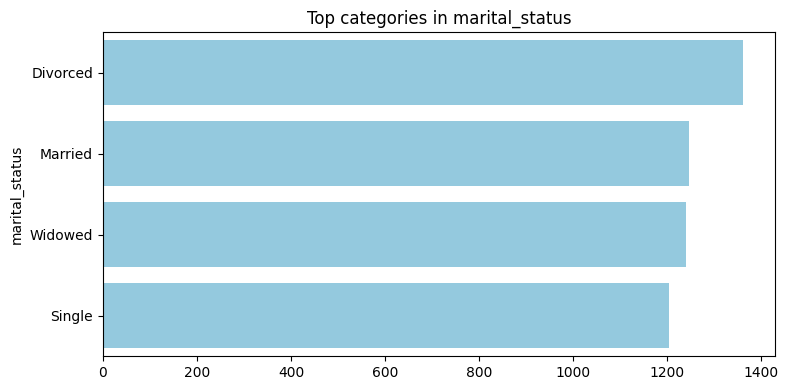

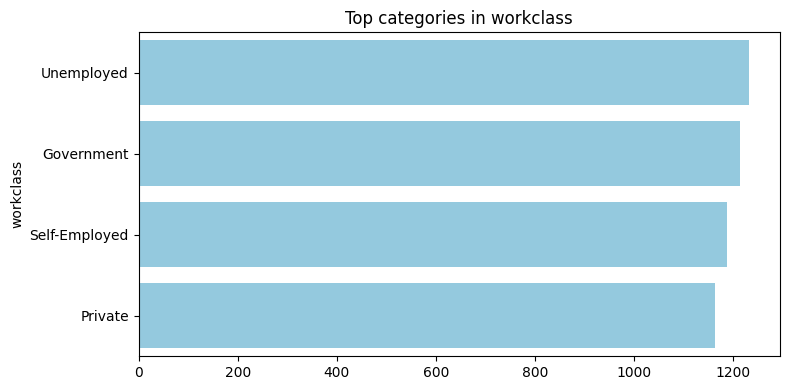

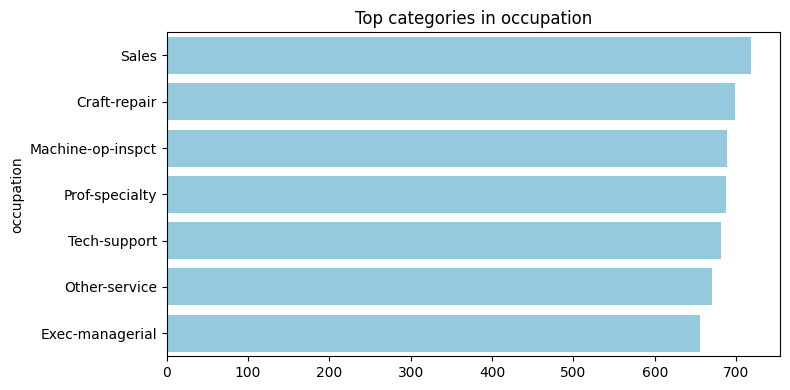

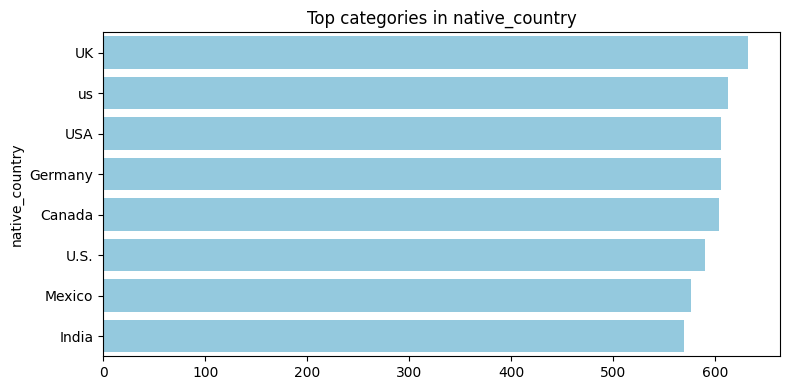

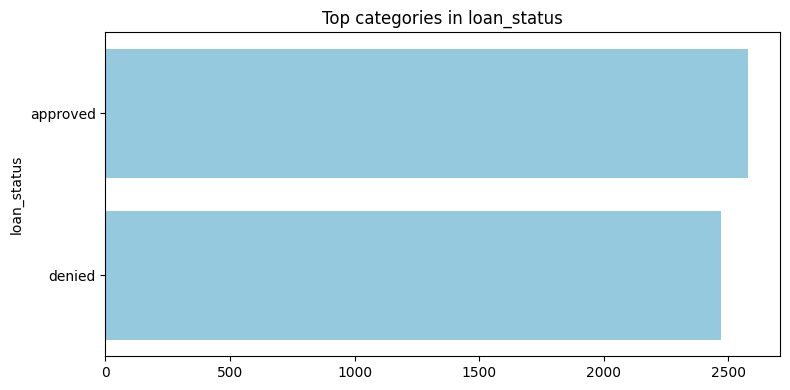

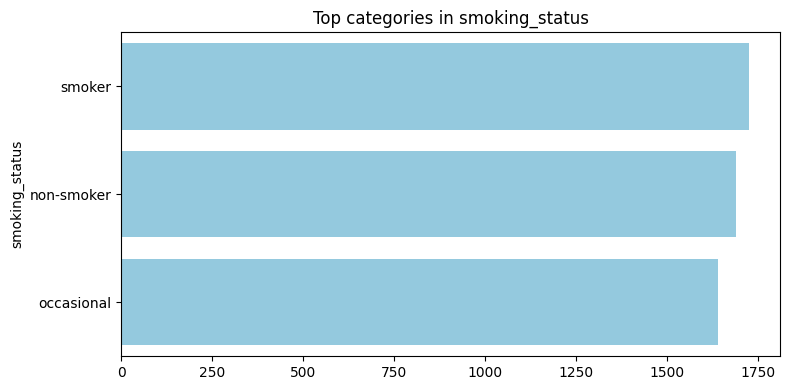

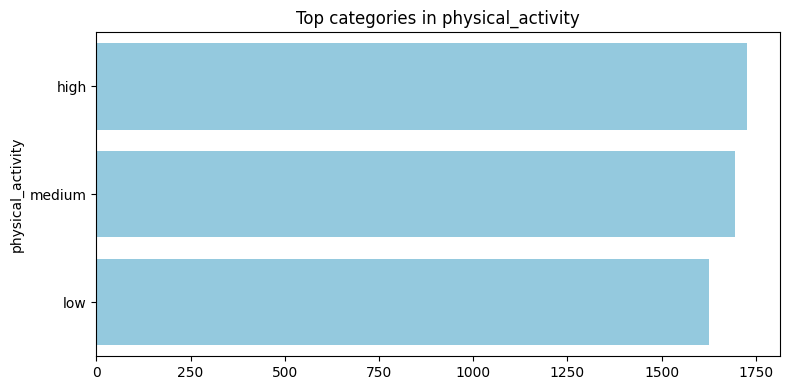

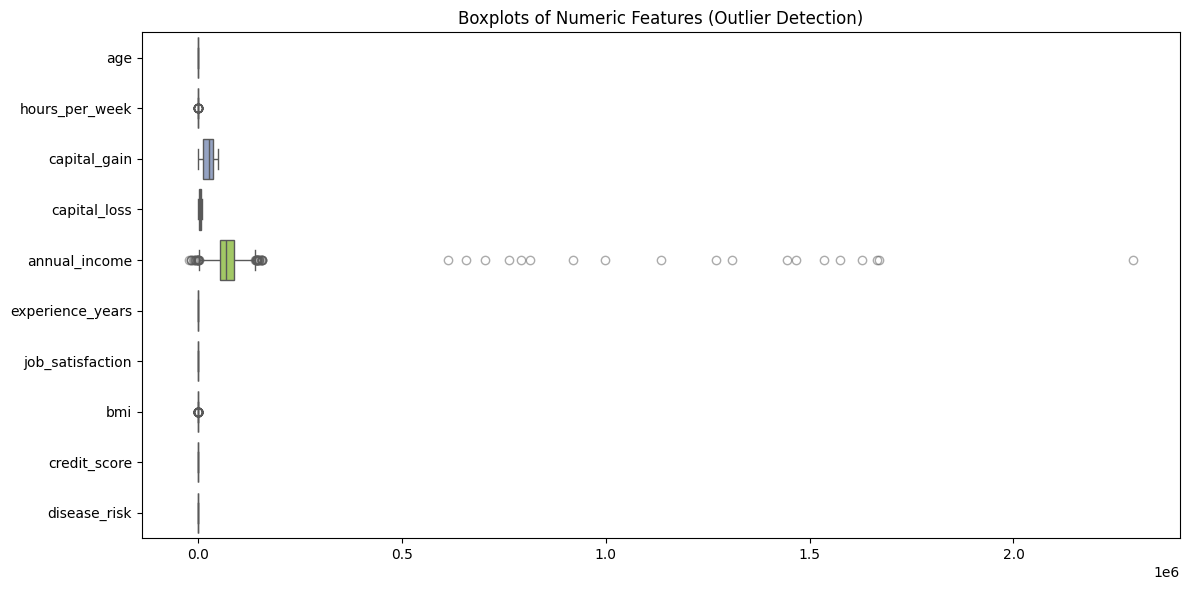

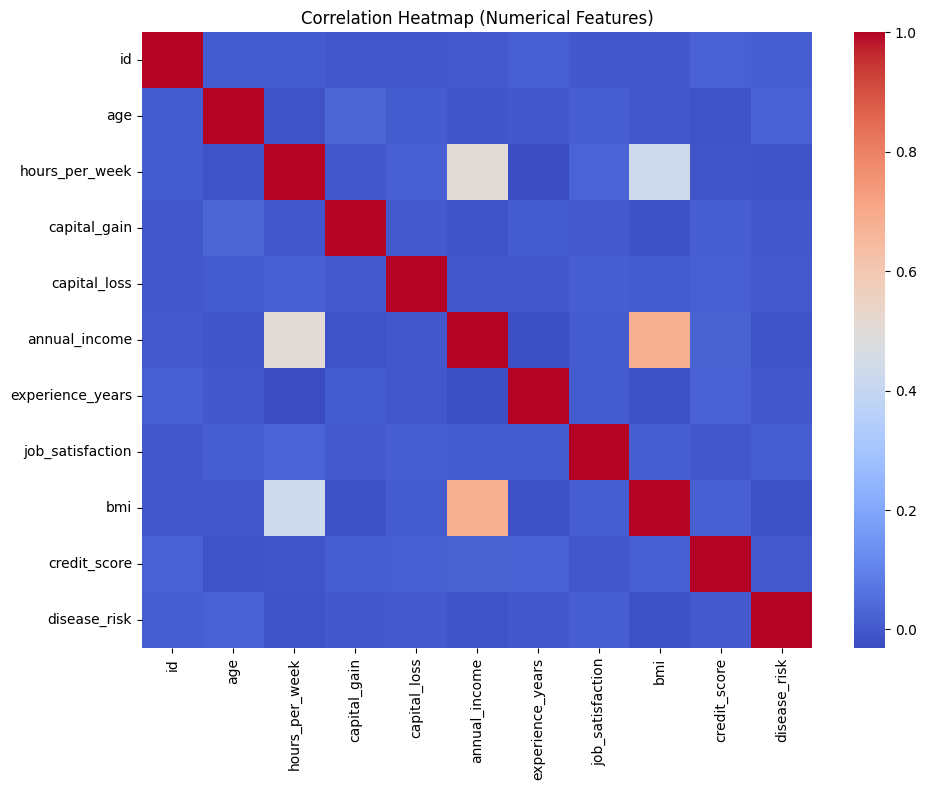


--- Categorical Columns Summary ---
              Column  Unique Values  \
0             gender              3   
1          education              4   
2     marital_status              4   
3          workclass              4   
4         occupation              7   
5     native_country              6   
6        loan_status              2   
7     smoking_status              3   
8  physical_activity              3   

                                   Sample Categories  
0                              [female, other, male]  
1             [masters, phd, bachelors, high school]  
2               [married, divorced, single, widowed]  
3   [unemployed, government, self-employed, private]  
4  [other-service, sales, tech-support, prof-spec...  
5         [united_states, india, uk, mexico, canada]  
6                                 [denied, approved]  
7                   [occasional, smoker, non-smoker]  
8                                [medium, low, high]  

Label Encoded: gender

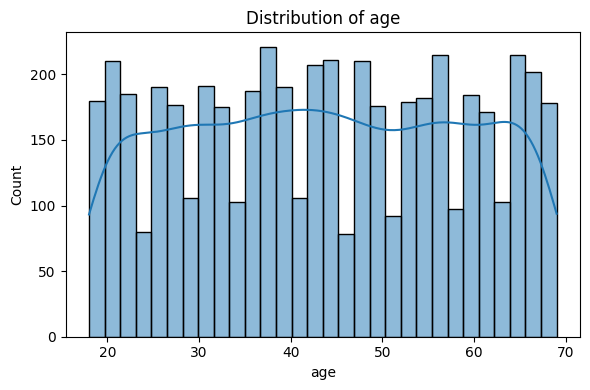

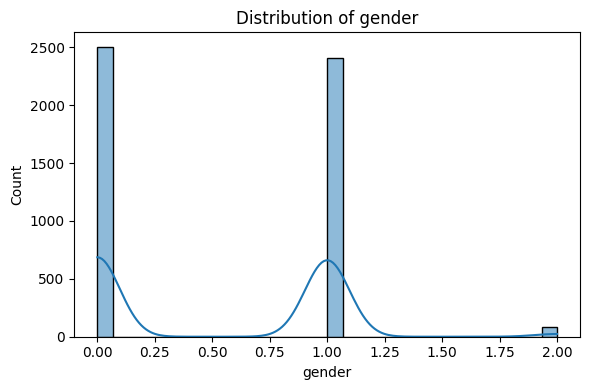

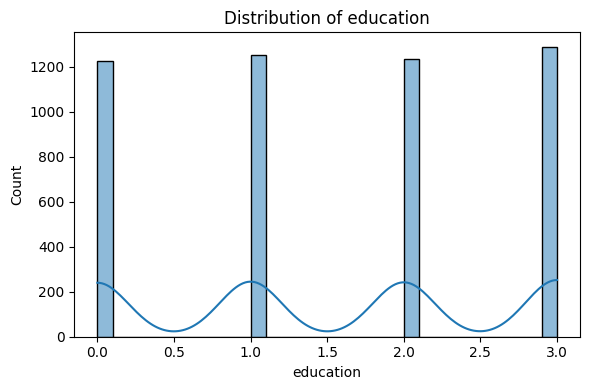

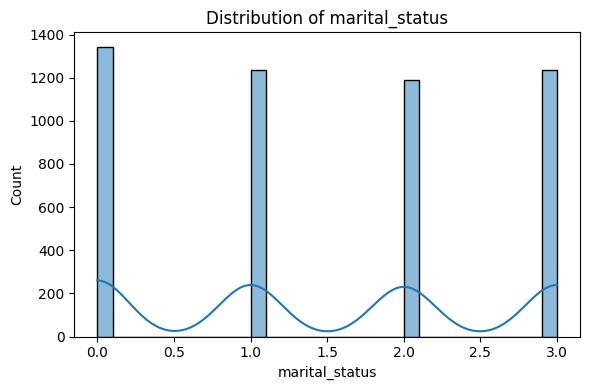

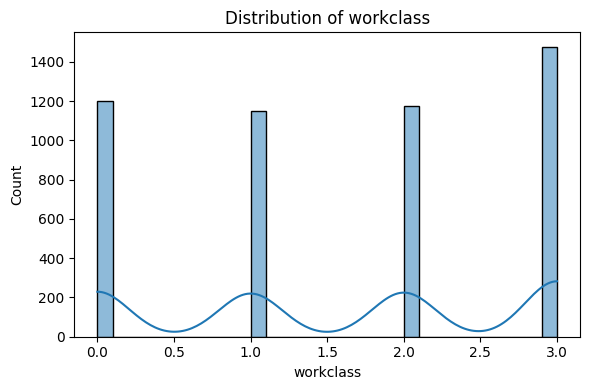

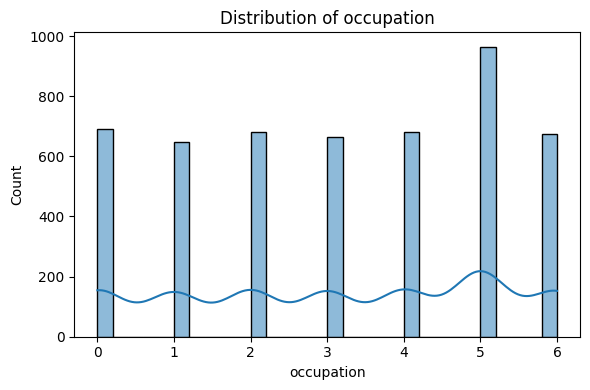

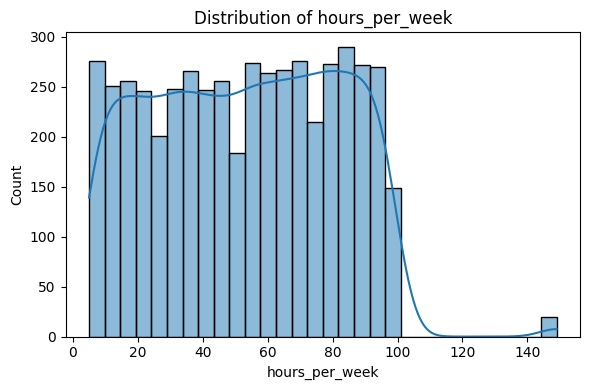

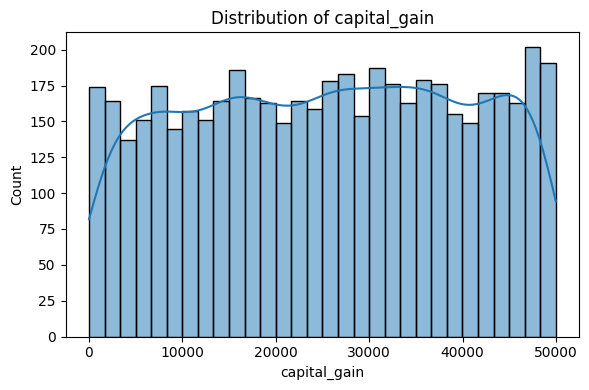

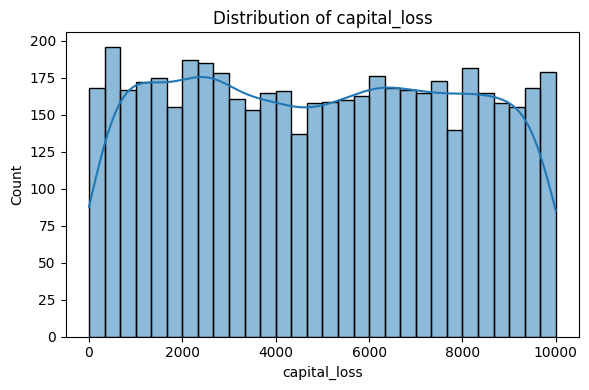

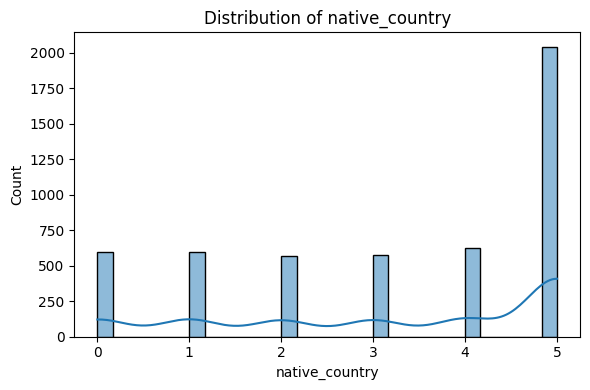

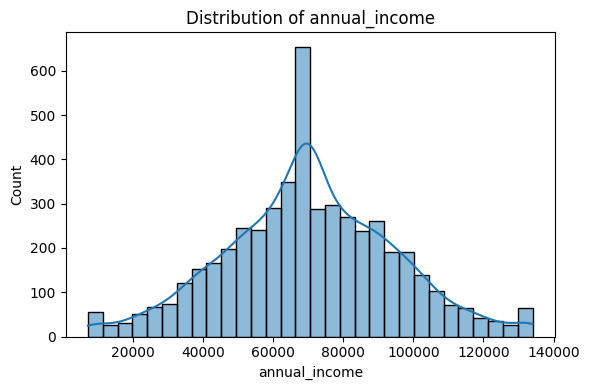

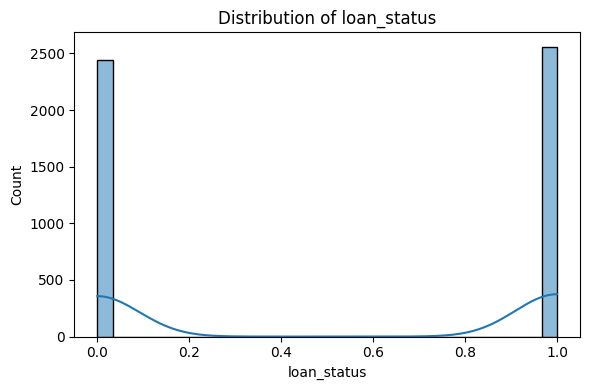

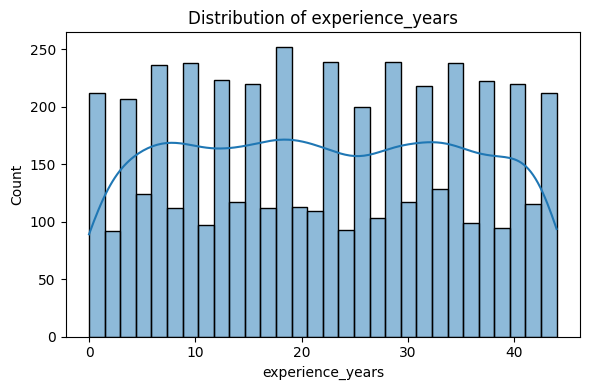

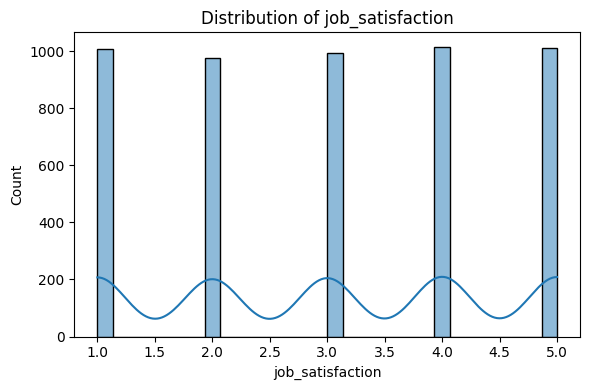

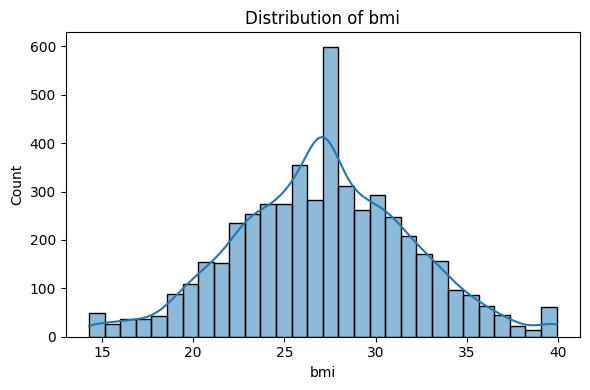

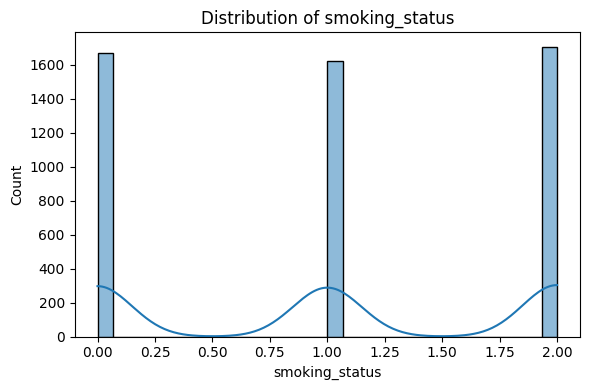

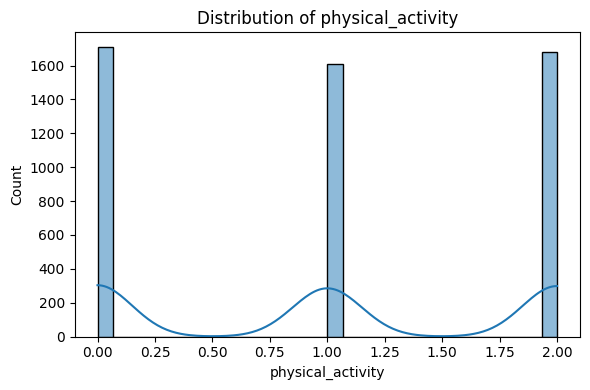

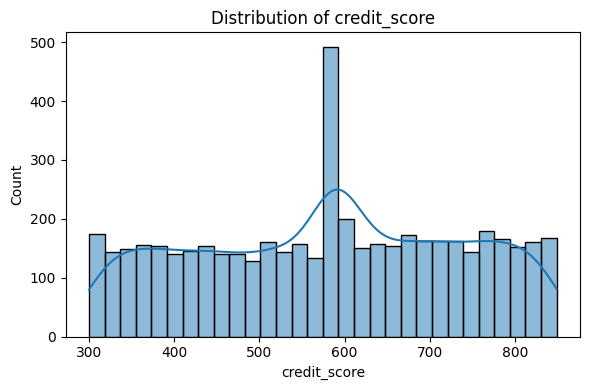

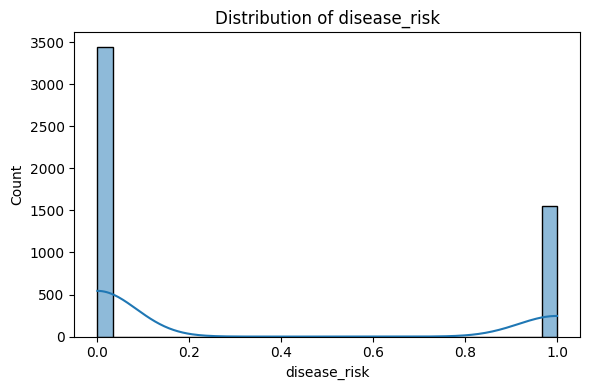

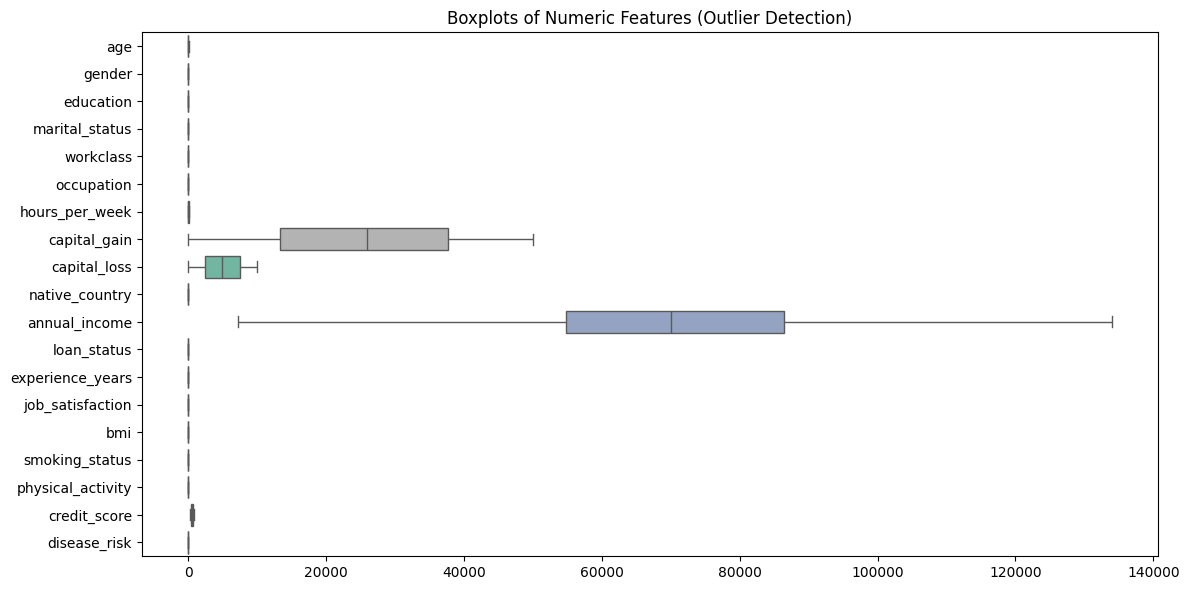

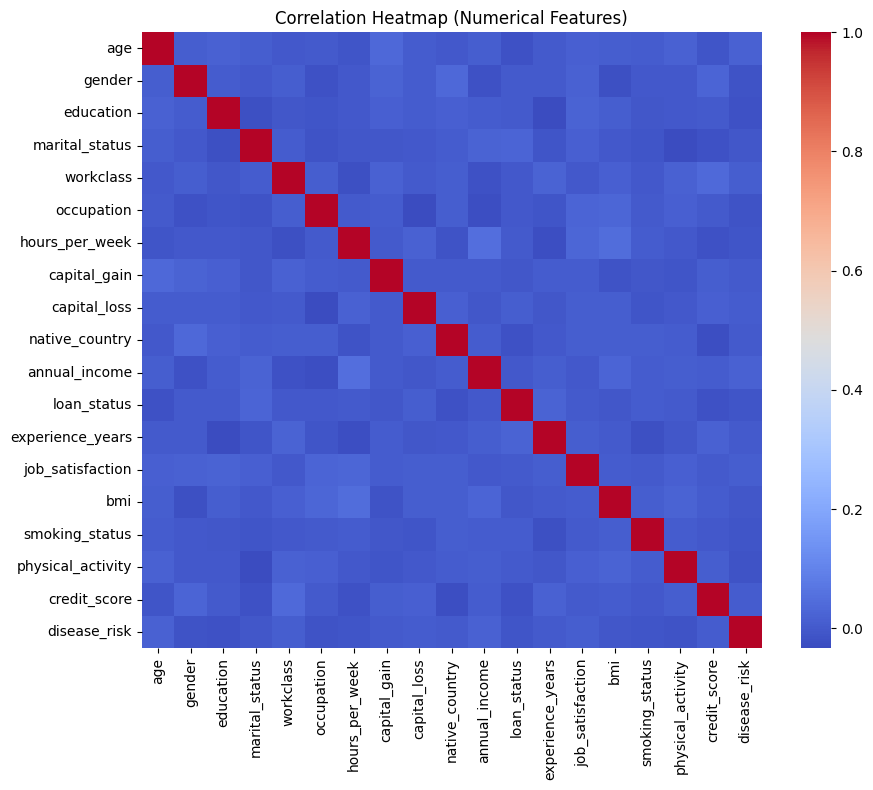

In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#----------------------------------------------------EDA Before----------------------------------------------------------
DATA_PATH = "DataSet1.csv"

# Treat ?, blank cells, and "unknown" (case insensitive) as missing
na_values = ["?", "unknown", "Unknown", " UNKNOWN", ""]
df = pd.read_csv(DATA_PATH, na_values=na_values)

# Step 2: Basic dataset info
print("\n--- Shape ---\n", df.shape)
print("\n--- Column Names ---\n", df.columns.tolist())
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Missing values per column ---\n", df.isnull().sum())
print("\n--- Summary statistics (numeric) ---\n", df.describe().T)
print("\n--- Summary statistics (categorical) ---\n", df.describe(include=[object]).T)
print("\n--- Duplicates ---\n", df.duplicated().sum())

# Step 3: Distribution plots (numeric features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop ID-like column from numeric distribution
num_cols = [c for c in num_cols if c.lower() not in ["id"]]

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# Step 4: Bar plots (categorical features)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    vc = df[col].value_counts(dropna=False).nlargest(10)
    sns.barplot(x=vc.values, y=vc.index, color="skyblue")
    plt.title(f"Top categories in {col}")
    plt.tight_layout()
    plt.show()

# Step 5: Boxplots for outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[num_cols],
    orient="h",
    palette="Set2",
    flierprops={"marker": "o", "color": "red", "alpha": 0.5}
)
plt.title("Boxplots of Numeric Features (Outlier Detection)")
plt.tight_layout()
plt.show()

# Step 6: Correlation Heatmap (numeric features only)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()

#-------------------------------------------------------PRE PROCESSING-------------------------------------------------------------
DATA_PATH = "DataSet1.csv"
na_values = ["?", "unknown", "Unknown", " UNKNOWN", ""]
df = pd.read_csv(DATA_PATH, na_values=na_values)

# Drop irrelevant columns
if "id" in df.columns:
    df = df.drop(columns=["id"])

# Step 2: Fix formatting issues
# --- Clean native_country column ---
if "native_country" in df.columns:
    df["native_country"] = (
        df["native_country"]
        .str.lower()
        .str.strip()
        .str.replace(r"[^\w\s]", "", regex=True)  # remove punctuation
    )

    # Define mapping for common variants of USA
    country_mapping = {
        "us": "united_states",
        "USA": "united_states",
        "usa": "united_states",
        "united states": "united_states",
        "unitedstates": "united_states",
        "U.S.": "united_states",
        "us": "united_states",
        "america": "united_states",
    }
    df["native_country"] = df["native_country"].replace(country_mapping)

# --- Standardize all categorical string values ---
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols:
    df[col] = df[col].str.strip().str.lower()

# Step 2.5: Drop duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

# Step 3: Handle missing values
# Median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Mode
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Step 4: Handle outliers (IQR capping)
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))

# Step 5: Encoding categorical features
print("\n--- Categorical Columns Summary ---")
summary = pd.DataFrame({
    "Column": cat_cols,
    "Unique Values": [df[c].nunique() for c in cat_cols],
    "Sample Categories": [df[c].unique()[:5] for c in cat_cols]
})
print(summary)

for col in cat_cols:
    n_unique = df[col].nunique()

    if n_unique > 2:   #>=3 values → Label Encoding
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"\nLabel Encoded: {col} ({n_unique} categories)")
        print("Mapping:", mapping)

    elif n_unique == 2:   #Binary encoding (0/1)
        unique_vals = list(df[col].unique())
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        df[col] = df[col].map(mapping).astype(int)
        print(f"\nBinary Encoded: {col} ({n_unique} categories → 0/1)")
        print("Mapping:", mapping)

    else:   #One-hot encoding (rare: only 1 unique category left)
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True).astype(int)
        dummies.index = df.index
        df = pd.concat([df.drop(columns=[col]), dummies], axis=1)
        print(f"\nOne-Hot Encoded: {col} ({n_unique} categories)")

# Step 6: Save preprocessed dataset
print("\n--- After Preprocessing ---")
print(df.head())
print("\nShape:", df.shape)
OUTPUT_PATH = "DataSet1_cleaned.csv"
df.to_csv(OUTPUT_PATH, index=False)

#---------------------------------------------------EDA AFTER-----------------------------------------------------------------------
DATA_PATH = "DataSet1_cleaned.csv"
df = pd.read_csv(DATA_PATH)

# EDA - AFTER preprocessing
print("\n--- Shape ---", df.shape)
print("\n--- Column Names ---", df.columns.tolist())
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Missing values per column ---", df.isnull().sum())
print("\n--- Summary statistics (numeric) ---\n", df.describe().T)
print("\n--- Duplicates ---", df.duplicated().sum())

# Distribution plots (numerical)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num_cols], orient="h", palette="Set2",
            flierprops={"marker": "o", "color": "red", "alpha": 0.5})
plt.title("Boxplots of Numeric Features (Outlier Detection)")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()
